# Fiber Bundle Representations

In [1]:
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.activations import relu
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Concatenate, Dense, Input
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.regularizers import l1

In [2]:
%load_ext tikzmagic

This notebook examines Fiber Bundles as State Representations. At a high level, fiber bundle state representations attempt to model the state $\mathcal{X}$ of a reinforcement learning task with action space $\mathcal{A}$, reward $\rho : \mathcal{X} \times \mathcal{A} \to \mathbf{R}$, and transition $P: \mathcal{X} \times \mathcal{A} \to \mathcal{X}$ through a fiber bundle of $\mathcal{X}$ over task-relevant information $\mathcal{S}$ and task-irrelevant information $\mathcal{W}$ manifolds, such that the reward and transition factor through $\mathcal{S}$ as illustrated below.

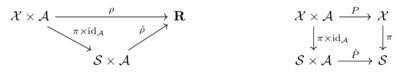

In [3]:
%%tikz -p amsmath -p tikz-cd

\draw node at (0, 0){
    \begin{tikzcd}
        \mathcal{X} \times \mathcal{A} \arrow[rr, "\rho"] \arrow[dr, "\pi \times \mathrm{id}_\mathcal{A}"] & & \mathbf{R} & & & \mathcal{X} \times \mathcal{A} \arrow[r, "P"] \arrow[d, "\pi \times \mathrm{id}_\mathcal{A}"] &  \mathcal{X} \arrow[d, "\pi"] \\
        & \mathcal{S} \times \mathcal{A} \arrow[ur, "\hat{\rho}"] & & & & \mathcal{S} \times \mathcal{A} \arrow[r, "\hat{P}"] & \mathcal{S}
    \end{tikzcd}
};

Fiber bundles attempt to form the state representation by implicitly learning the fiber bundle, its submersions onto $\mathcal{S}$ and $\mathcal{W}$, and the lift from both back to $\mathcal{X}$ by constructing approximation manifolds $\mathcal{S}_\phi$ and $\mathcal{W}_\phi$ dictated by $\phi : \mathcal{X} \to \mathcal{S}_\phi$ and $\omega_\phi : \mathcal{X} \to \mathcal{W}_\phi$.

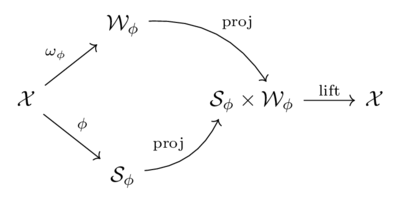

In [4]:
%%tikz -p amsmath -p tikz-cd

\draw node at (0, 0){
    \begin{tikzcd}
        & \mathcal{W}_\phi \arrow[dr, "\mathrm{proj}", end anchor={[xshift=-4ex,yshift=2ex]east}, bend left]\\
    \mathcal{X} \arrow[ur, "\omega_\phi"] \arrow[dr, "\phi"] & & \mathcal{S}_\phi \times \mathcal{W}_\phi \rar{\mathrm{lift}} & \mathcal{X} \\
        & \mathcal{S}_\phi \arrow[ur, "\mathrm{proj}", bend right, end anchor={[xshift=2ex, yshift=-2ex]west}]
    \end{tikzcd}
};

We prove that if such $\mathcal{S}$ exists, then it is unique up to isometry. From this property, we can derive several loss functions which when minimized would produce $\mathcal{S} \simeq \mathcal{S}_\phi$. We cover the first of these, based on [Plan2Vec](https://arxiv.org/pdf/2005.03648.pdf) below.

## Bundle Representation Plan2Vec Loss

In [3]:
from bundle_arch import BRepPlan2VecEstimator, BRepPlan2VecKerasTrainModel

We begin with an elementary example where $\mathcal{X} = \mathbf{R}^2$ and $\mathcal{S}$ is the first coordinate and $\mathcal{W}$ is the second coordinate. We construct the following simple Tensorflow model to illustrate the Bundle Representatino loss.

In [4]:
## First we must define the distance functions on both X and S
def simple_rep_dist(x1, x2):
    """The desired representation distance for test_simple (l2)
    Arguments:
        x1: a tf tensor
        x2: a tf tensor of the same shape as x1
    """
    return tf.math.reduce_sum(tf.math.square(x1 - x2))

def simple_input_dist(x1, x2):
    """The desired input distance for test_simple (l2)
    Arguments:
        x1: a tf tensor
        x2: a tf tensor of the same shape as x1
    """
    return tf.math.reduce_sum(tf.math.square(x1 - x2))

In [5]:
def linear(x):
    return relu(x, alpha=1.0)

In [16]:
## Now we define our desired architecture
inp = Input(shape=(2,), name='X')
rep = Dense(1, activation=linear, name='S', use_bias=False)(inp)  # want first
fiber = Dense(1, activation=linear, name='W', use_bias=False)(inp)  # want second
rep_inp = Input(shape=(1,), name='S_out')
fiber_inp = Input(shape=(1,), name='W_out')
con = Concatenate(name='SxW')([rep_inp, fiber_inp])
outp = Dense(2, activation=linear, name='Xreconstr', use_bias=False)(con)  # want identity matrix

rep_model = tf.keras.Model(inputs=inp, outputs=rep, name='rep')
fiber_model = tf.keras.Model(inputs=inp, outputs=fiber, name='fiber')
reconstr_model = tf.keras.Model(inputs=[rep_inp, fiber_inp],
                                outputs=[outp], name='reconstr')

start_correct = False

if start_correct:
    rep_model.get_layer(index=1).set_weights([np.array([1, 0])
                                              .reshape(-1, 1)])
    fiber_model.get_layer(index=1).set_weights([np.array([0, 1])
                                                .reshape(-1, 1)])
    reconstr_model.get_layer(index=3).set_weights([np.array([1, 0, 0, 1])
                                                   .reshape(2, 2)])
else:
    rep_model.get_layer(index=1).set_weights([np.array([0, 1])
                                              .reshape(-1, 1)])
    fiber_model.get_layer(index=1).set_weights([np.array([1, 0])
                                                .reshape(-1, 1)])
    reconstr_model.get_layer(index=3).set_weights([np.array([0, 1, 1, 0])
                                                   .reshape(2, 2)])

model = BRepPlan2VecEstimator(rep_model=rep_model,
                              fiber_model=fiber_model,
                              reconstr_model=reconstr_model,
                              reconstr_loss=keras.losses.mean_squared_error,
                              rep_dist=simple_rep_dist,
                              input_dist=simple_input_dist,
                              loss_w=3,
                              optimizer=RMSprop(learning_rate=0.0005),
                              epochs=10, batch_size=100)

In [7]:
# Just a reconstruction model

reconstr = reconstr_model([rep, fiber])
whole_model = tf.keras.Model(inputs=inp,
                             outputs=[rep, fiber, reconstr],
                             name='encoder_decoder')

def whole_reconstr_loss(y_true, y_pred):
    rep1 = y_pred[0]
    fiber1 = y_pred[1]
    reconstr1 = y_pred[2]
    return keras.losses.MSE(y_true, reconstr1)

whole_model.compile(loss=whole_reconstr_loss,
                    optimizer=RMSprop(learning_rate=0.0001))

In [8]:
# Just the bundle rep plan2vec model

inp1 = Input(shape=(2,), name='X_train_1')
inp2 = Input(shape=(2,), name='X_train_2')

rep1 = rep_model(inp1)
rep2 = rep_model(inp2)

fiber1 = fiber_model(inp1)

reconstr1 = reconstr_model([rep1, fiber1])
reconstr2 = reconstr_model([rep2, fiber1])

def brep_loss(y_true, y_pred):
    rep1 = y_pred[0]
    fiber1 = y_pred[1]
    reconstr1 = y_pred[2]
    rep2 = y_pred[3]
    reconstr2 = y_pred[4]

    inp1 = y_true[0, :]
    inp2 = y_true[1, :]

    dist_reconstr = simple_input_dist(reconstr1, reconstr2)
    dist_rep = simple_rep_dist(rep1, rep2)
    return (1 * (keras.losses.MSE(inp1, reconstr1) +
                   keras.losses.MSE(inp2, reconstr2)) +
            2 * (dist_reconstr - dist_rep) * (dist_reconstr - dist_rep))
    
brep_model = tf.keras.Model(inputs=[inp1, inp2],
                            outputs=[rep1, fiber1, reconstr1,
                                     rep2, reconstr2])
brep_model.compile(optimizer=RMSprop(learning_rate=0.0001),
                   loss=brep_loss)

Let's compare the data flow graphs of the train model and test model:

In [9]:
%load_ext tensorboard
%env PATH=../../../env/bin:$PATH
import datetime

env: PATH=../../../env/bin:$PATH


In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

In [11]:
def print_model(model, X):
    # Get the plots of the original input, then reconstructed, and reps/fibers
    print(model.get_layer(index=1).get_weights())
    print(model.get_layer(index=2).get_weights())
    print(model.get_layer(index=3).get_weights())

    # The representations, fibers, and reconstructed
    outs = model.predict(X)
    reps = outs[0]
    fibers = outs[1]
    reconstrX = outs[2]

    fig, ((ax1, ax2),
          (ax3, ax4),
          (ax5, ax6)) = plt.subplots(3, 2, figsize=(20, 30))
    colors = [(0.5 * x[0] + 0.5, 0, 0.5 * x[1] + 0.5)
              for x in X]

    # The originals
    ax1.scatter(X[:, 0], X[:, 1], c=colors)
    ax1.set_title('Input')
    ax1.set_xlabel('x')
    ax1.set_xlim(-0.1, 1.1)
    ax1.set_ylabel('y')
    ax1.set_ylim(-0.1, 1.1)

    # The reconstructed
    ax2.scatter(reconstrX[:, 0], reconstrX[:, 1], c=colors)
    ax2.set_title('Reconstructed')
    ax2.set_xlabel('x')
    ax2.set_xlim(-0.1, 1.1)
    ax2.set_ylabel('y')
    ax2.set_ylim(-0.1, 1.1)

    # The representation given different inputs (plot x[0])
    ax3.scatter(X[:, 0], reps, c=colors)
    ax3.set_title('Representation (by first coordinate)')
    ax3.set_xlabel('x_0')
    ax3.set_xlim(-0.1, 1.1)
    ax3.set_ylabel('representation')
    ax3.set_ylim(-0.1, 1.1)

    # The representation given different inputs (plot x[1])
    ax4.scatter(X[:, 1], reps, c=colors)
    ax4.set_title('Representation (by second coordinate)')
    ax4.set_xlabel('x_1')
    ax4.set_xlim(-0.1, 1.1)
    ax4.set_ylabel('representation')
    ax4.set_ylim(-0.1, 1.1)

    # The fiber given different inputs (plot x[0])
    ax5.scatter(X[:, 0], fibers, c=colors)
    ax5.set_title('Fiber (by first coordinate)')
    ax5.set_xlabel('x_0')
    ax5.set_xlim(-0.1, 1.1)
    ax5.set_ylabel('fiber value')
    ax5.set_ylim(-0.1, 1.1)

    # The fiber given different inputs (plot x[1])
    ax6.scatter(X[:, 1], fibers, c=colors)
    ax6.set_title('Fiber (by second coordinate)')
    ax6.set_xlabel('x_1')
    ax6.set_xlim(-0.1, 1.1)
    ax6.set_ylabel('fiber value')
    ax6.set_ylim(-0.1, 1.1)

In [12]:
# Define the training data (note that distances are implicit previously)
X = np.array([[x1, x2]
              for x1 in np.linspace(0, 1, 10)
              for x2 in np.linspace(0, 1, 10)]).reshape(100, 2)

_paired_X = [(x1, x2)
             for (i1, x1) in enumerate(X[:, :])
             for (i2, x2) in enumerate(X[:, :])]
paired_X = [np.array([x[0] for x in _paired_X]),
            np.array([x[1] for x in _paired_X])]
paired_y = np.array([np.vstack((xs[0], xs[1]))
                     for xs in _paired_X])

Epoch 1/100
10/10 [==============================] - 0s 1ms/step - loss: 0.6078 - S_loss: 0.1921 - W_loss: 0.2237 - reconstr_loss: 0.1920
Epoch 2/100
10/10 [==============================] - 0s 1ms/step - loss: 0.5212 - S_loss: 0.1790 - W_loss: 0.1794 - reconstr_loss: 0.1627
Epoch 3/100
10/10 [==============================] - 0s 2ms/step - loss: 0.5520 - S_loss: 0.1886 - W_loss: 0.1723 - reconstr_loss: 0.1911
Epoch 4/100
10/10 [==============================] - 0s 2ms/step - loss: 0.6800 - S_loss: 0.1881 - W_loss: 0.2690 - reconstr_loss: 0.2229
Epoch 5/100
10/10 [==============================] - 0s 2ms/step - loss: 0.4877 - S_loss: 0.1813 - W_loss: 0.1500 - reconstr_loss: 0.1564
Epoch 6/100
10/10 [==============================] - 0s 2ms/step - loss: 0.5718 - S_loss: 0.1900 - W_loss: 0.1937 - reconstr_loss: 0.1881
Epoch 7/100
10/10 [==============================] - 0s 1ms/step - loss: 0.5244 - S_loss: 0.1694 - W_loss: 0.1857 - reconstr_loss: 0.1693
Epoch 8/100
10/10 [===============

10/10 [==============================] - 0s 1ms/step - loss: 0.5140 - S_loss: 0.1701 - W_loss: 0.1894 - reconstr_loss: 0.1545
Epoch 61/100
10/10 [==============================] - 0s 1ms/step - loss: 0.5181 - S_loss: 0.2074 - W_loss: 0.1497 - reconstr_loss: 0.1610
Epoch 62/100
10/10 [==============================] - 0s 1ms/step - loss: 0.6185 - S_loss: 0.2358 - W_loss: 0.1801 - reconstr_loss: 0.2026
Epoch 63/100
10/10 [==============================] - 0s 1ms/step - loss: 0.6120 - S_loss: 0.1937 - W_loss: 0.2303 - reconstr_loss: 0.1880
Epoch 64/100
10/10 [==============================] - 0s 2ms/step - loss: 0.6153 - S_loss: 0.2314 - W_loss: 0.1829 - reconstr_loss: 0.2010
Epoch 65/100
10/10 [==============================] - 0s 1ms/step - loss: 0.5430 - S_loss: 0.1663 - W_loss: 0.2096 - reconstr_loss: 0.1671
Epoch 66/100
10/10 [==============================] - 0s 1ms/step - loss: 0.5102 - S_loss: 0.1334 - W_loss: 0.2081 - reconstr_loss: 0.1686
Epoch 67/100
10/10 [====================

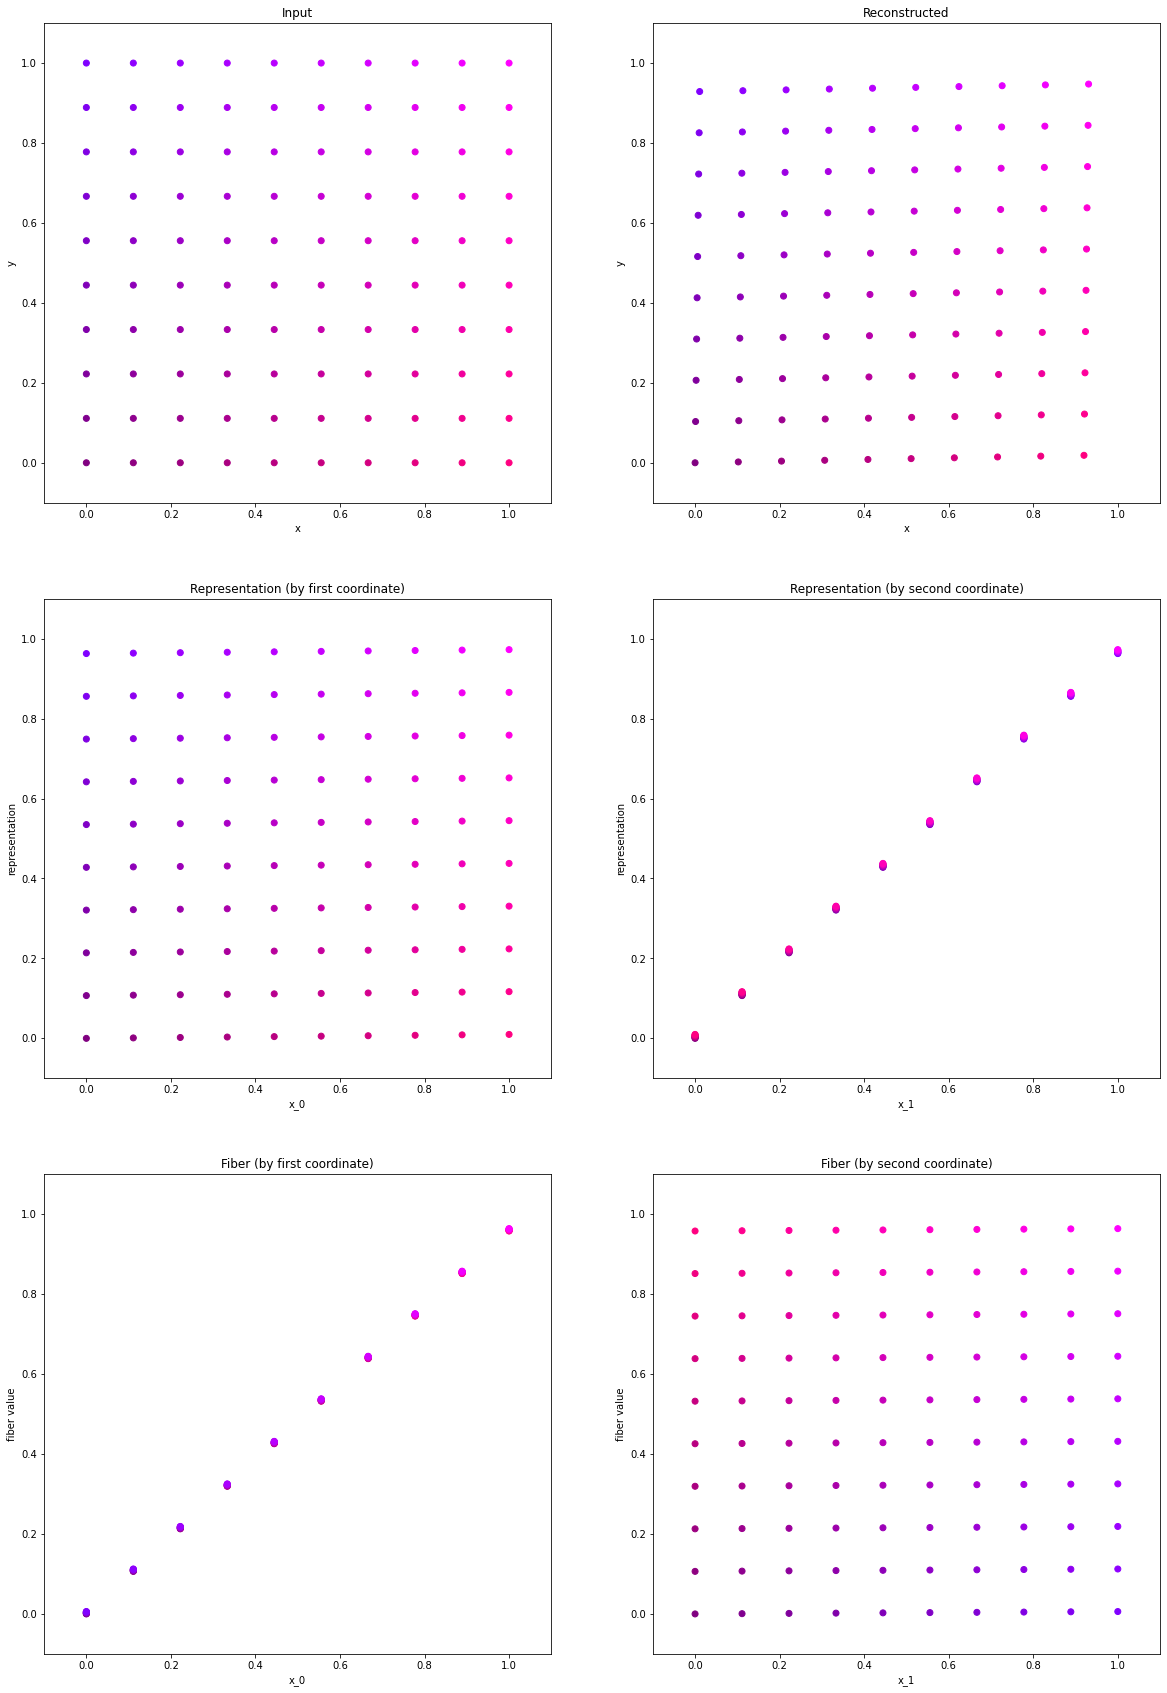

In [13]:
# With the given setup, then the trained model should be able to
# reconstruct the input and rep = inp[0] and fiber = inp[1]
tf.random.set_seed(0)

whole_model.fit(X, X, epochs=100, batch_size=10)

print_model(whole_model, X)

[array([[0.10764356],
       [0.6628397 ]], dtype=float32)]
[array([[0.7117722],
       [0.0780362]], dtype=float32)]
[array([[0.07324977, 0.75612575],
       [0.7607052 , 0.08624319]], dtype=float32)]


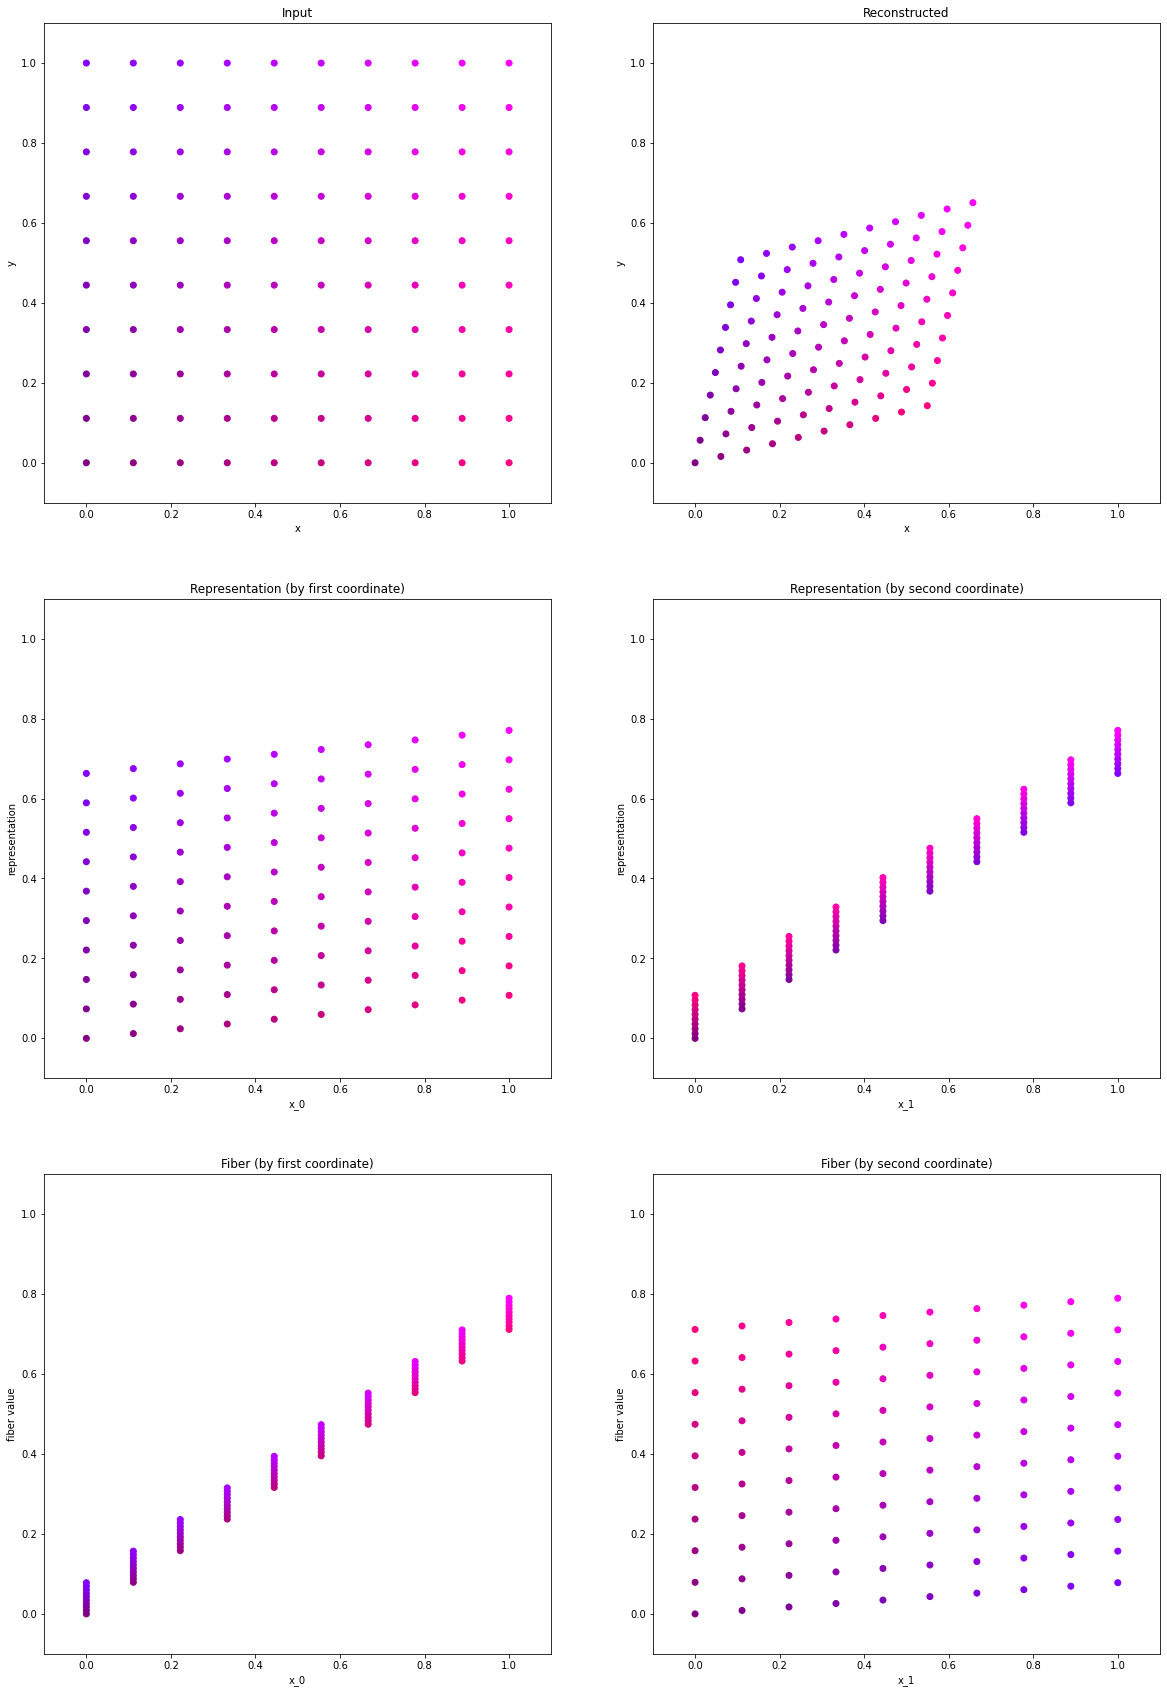

In [14]:
tf.random.set_seed(0)

brep_model.fit(paired_X,
               paired_y,
               epochs=500,
               batch_size=1000,
               verbose=0)

print_model(whole_model, X)

[array([[0.35830972],
       [0.36135054]], dtype=float32)]
[array([[0.37460262],
       [0.35770708]], dtype=float32)]
[array([[0.28025296, 0.60908663],
       [0.62725073, 0.31342772]], dtype=float32)]


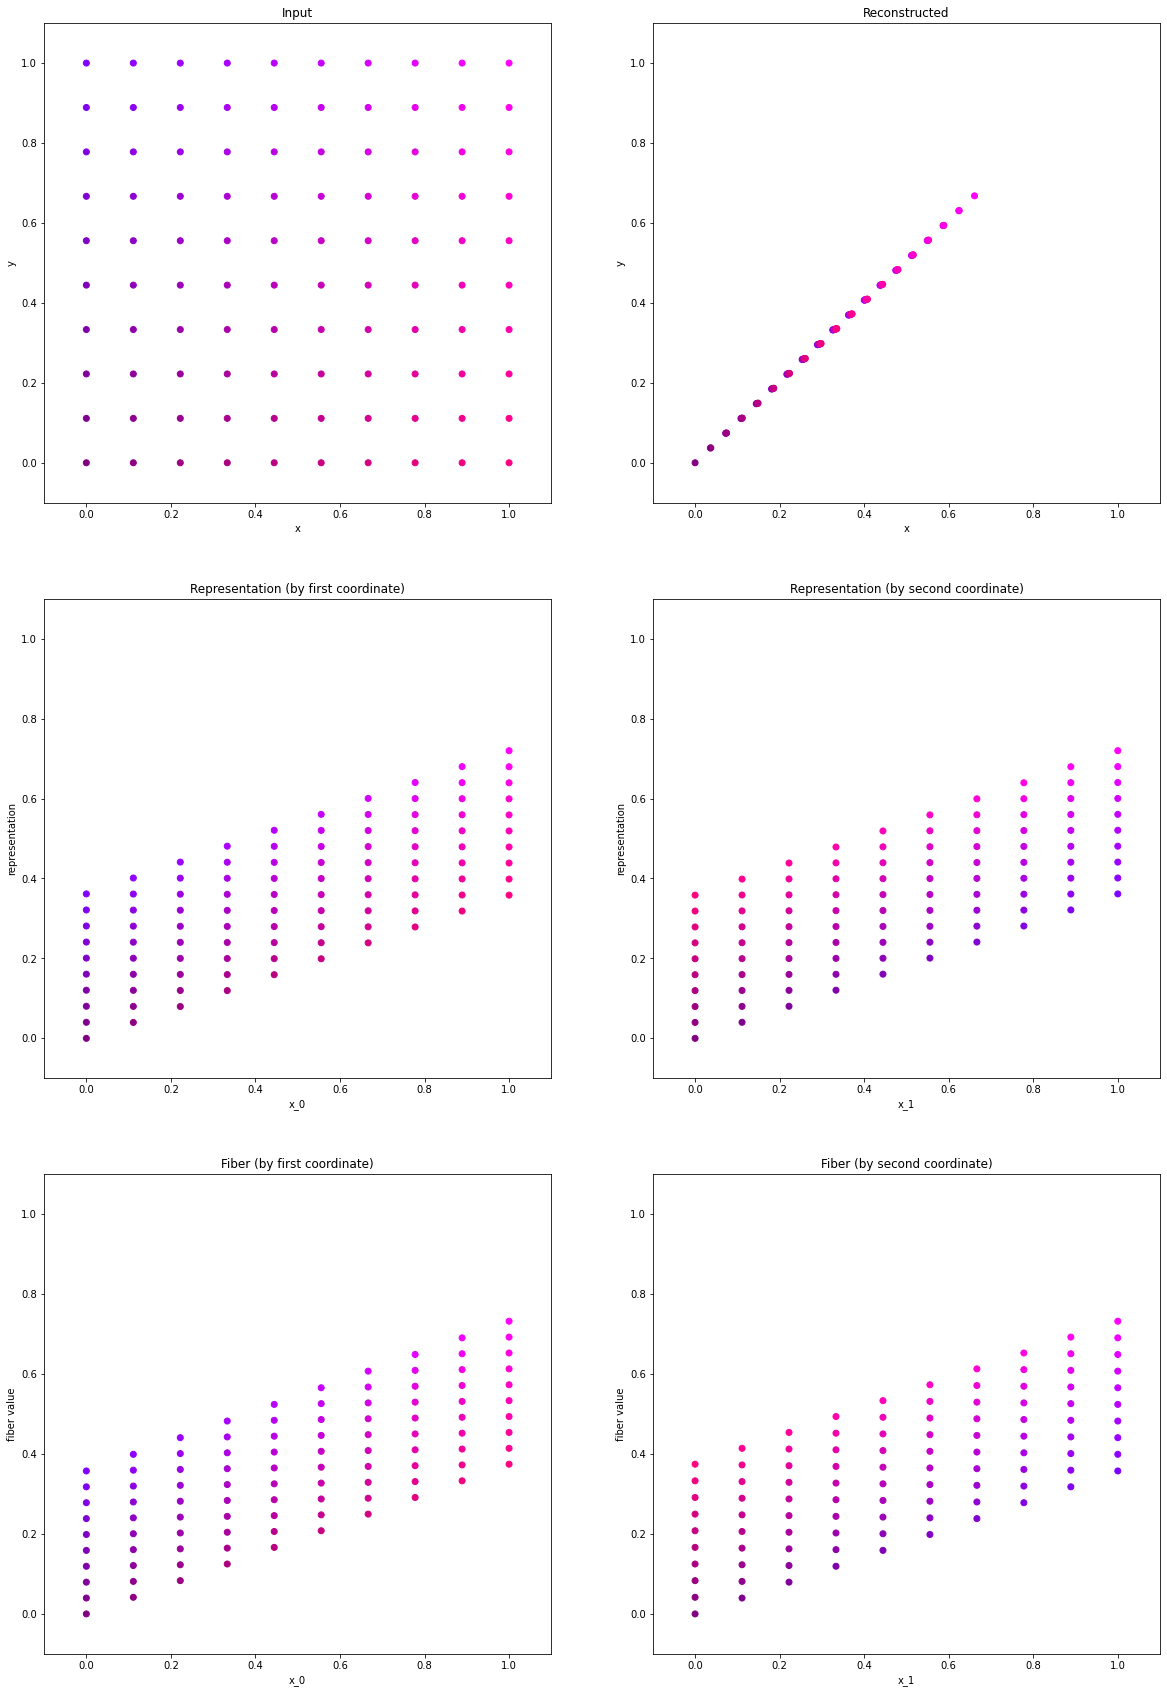

In [17]:
# Define the Keras TensorBoard callback.
logdir="logs/fit/" + datetime.datetime.now().strftime("linear_brep")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

tf.random.set_seed(0)

model.fit(X,
          epochs=1000,
          batch_size=1000,
          verbose=0,
          callbacks=[tensorboard_callback])

print_model(model.test_model, X)

In [16]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 4480), started 14 days, 4:04:11 ago. (Use '!kill 4480' to kill it.)

Let's see how it transforms the data after a single epoch.